In [9]:
%pip install spotipy --upgrade
%pip install lyricsgenius
%pip install textblob

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.cache_handler import CacheFileHandler

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=os.environ['SPOTIFY_CLIENT_ID'], client_secret=os.environ['SPOTIFY_CLIENT_SECRET'], cache_handler=CacheFileHandler(username='keatonconrad')))

ModuleNotFoundError: No module named 'spotipy'

# Importing Data

## Million Song Dataset

To start, we import a subset of the [Million Song Dataset](http://millionsongdataset.com/) and read it into a DataFrame with pandas for easy processing. The dataset contains random songs of various genres from 1922 to 2011. We'll use this to collect non-hit songs.

The DataFrame is shuffled to mitigate any bias in the order.

In [ ]:
song_data = pd.read_csv('./song-list.txt', sep='<SEP>', engine='python')
song_data = song_data.sample(frac=1)
song_data.describe()

## Spotify and Billboard Data

We import a dataset that contains historical Billboard Hot 100 data mapped to each song's Spotify ID. This is incredibly useful as it helps us collect the audio features later. This dataset will be used to collect features from hit songs.

Like the previous dataset, we shuffle it to avoid any ordering bias.

In [ ]:
spotify_billboard_data = pd.read_csv('./spotify-billboard-data.csv')
spotify_billboard_data = spotify_billboard_data.sample(frac=1)
print(spotify_billboard_data.columns)
hit_track_ids = spotify_billboard_data['spotify_track_id'].tolist()
spotify_billboard_data.describe()

# Data Enrichment

In [ ]:
def get_track_info(track, hit):
    # Helper function to clean up code later
    
    explicit = 1 if track['explicit'] else 0
    try:
        isrc = track['external_ids']['isrc']
    except KeyError:
        isrc = None
        
    return {
        'spotify_track_id': track['id'],
        'isrc': isrc,
        'artist': track['artists'][0]['name'],
        'artist_id': track['artists'][0]['id'],
        'song': track['name'],
        'spotify_track_album': track['album']['name'],
        'year': track['album']['release_date'][:4],
        'explicit': explicit,
        'hit': hit,
        'current_popularity': track['popularity'] # As of 4/20/21
    }

## Non-Hit Songs

We can't do much with just the song title and artist, as given in the Million Song Dataset. Here, we do a search on Spotify to find the closest matching song and retrieve the track ID, album, and explicit information, among other data.

It should be noted that this step has some inherent inaccuracy due to its reliance on Spotify's search feature. There is no guarantee the correct song will be returned.

In [ ]:
from tqdm import tqdm

no_hit_arr = []
song_data_sample = song_data.head(len(spotify_billboard_data))

for i, song in tqdm(song_data_sample.iterrows(), total=song_data_sample.shape[0]):
    artist = song['Performer'].replace('Featuring ', '').replace('feat. ', '').replace('feat ', '').replace('& ', '')
    search_results = spotify.search(q=song['Song'] + ' ' + artist, limit=1, type='track', market='US')
    try:
        track = search_results['tracks']['items'][0]
    except IndexError: # If search didn't return anything
        continue
        
    if track['id'] not in hit_track_ids:
        no_hit_arr.append(get_track_info(track, hit=0))

The data is consolidated into a DataFrame for ease of processing.

In [ ]:
no_hit_basic_song_data_df = pd.DataFrame(no_hit_arr)
no_hit_basic_song_data_df.describe()

## Hit Songs

While the Spotify and Billboard dataset provides more data than the Million Song Dataset we are using, we still collect more information from Spotify about the album and release year.

This step isn't necessarily required, as the album name isn't used for much. However, it is quick due to already having the track IDs.

In [ ]:
hit_arr = []
track_ids = []

for i, song in tqdm(spotify_billboard_data.iterrows(), total=spotify_billboard_data.shape[0]):
    track_ids.append(song['spotify_track_id'])
    
    if len(track_ids) == 50 or i == spotify_billboard_data.shape[0]:
        results = spotify.tracks(tracks=track_ids)['tracks']
        for track in results:            
            hit_arr.append(get_track_info(track, hit=1))
        track_ids.clear()

As before, the data is turned into a DataFrame.

In [ ]:
hit_basic_song_data_df = pd.DataFrame(hit_arr)
hit_basic_song_data_df.describe()

Now that we have basic information (and more importantly, the Spotify track IDs) from our dataset, we concatenate both the non-hits and the hits together into one larger dataset.

In [ ]:
basic_song_data_df = pd.concat([no_hit_basic_song_data_df, hit_basic_song_data_df])
basic_song_data_df = basic_song_data_df.sample(frac=1)
basic_song_data_df.head()

## Feature Collection

We collect the audio features for each track using the Spotify API and the track IDs from the newly created DataFrame.

Due to how the code makes API calls in batches of 100, it will ignore the last few tracks.

In [ ]:
features = []
track_ids = []

for track_id in tqdm(basic_song_data_df['spotify_track_id']):
    track_ids.append(track_id)
    if len(track_ids) == 100:
        results = spotify.audio_features(tracks=track_ids)
        for result in results:
            if result is None:
                # Sometimes it returns None, this sets a default so we can still add it to a df
                features.append({
                    'danceability': None,
                    'energy': None,
                    'key': None,
                    'loudness': None,
                    'mode': None,
                    'speechiness': None,
                    'acousticness': None,
                    'instrumentalness': None,
                    'liveness': None,
                    'valence': None,
                    'tempo': None,
                    'type': None,
                    'id': None,
                    'uri': None,
                    'track_href': None,
                    'analysis_url': None,
                    'duration_ms': None,
                    'time_signature': None
                })
            else:
                features.append(result)
        track_ids.clear()

In [ ]:
features_df = pd.DataFrame(features)
features_df.describe()

Due to the rounding-off of the last few songs as mentioned above, we ensure both the `basic_song_data_df` and the `features_df` are of equal length.

Finally, we concatenate them, forming one DataFrame with basic song information and the audio features of each track.

In [ ]:
print(len(basic_song_data_df))
print(len(features_df))

# features_df.drop(features_df.tail(24).index, inplace=True)

print(len(basic_song_data_df))
print(len(features_df))

basic_data = basic_song_data_df.reset_index(drop=True, inplace=False)
feature_data = features_df.reset_index(drop=True, inplace=False)

full_df = pd.concat([basic_data, feature_data], axis=1)
full_df.head()

In [ ]:
from scipy.stats import ttest_ind

"""
for column in full_df.columns:
    try:
        t = ttest_ind(hit_df[column].astype(float), no_hit_df[column].astype(float))
        print(column + ' - T: ' + str(t[0]) + ', p: ' + str(t[1]))
    except ValueError:
        continue
"""

For sanity's sake, we save the DataFrame for easy loading later.

In [ ]:
import pickle

df = full_df
with open('all_song_data_new.pickle', 'wb') as f:
    pickle.dump(pd.DataFrame(df), f)

In [ ]:
with open('all_song_data_new.pickle', 'rb') as f:
    df = pickle.load(f)

## Lyric Collection

Using the Genius API, we collect the lyrics of every song in our dataset. The polarity and subjectivity of the lyrics are also saved to an array.

Similar to above, this step has inherent inaccuracies due to its reliance on Genius's search feature.

The polariy, subjectivity, and lyrics are pickled and saved for easy loading later.

In [ ]:
import lyricsgenius
genius = lyricsgenius.Genius(os.environ['GENIUS_TOKEN'], verbose=False, remove_section_headers=True)

In [ ]:
import pickle
from tqdm import tqdm

lyrics = []

for i, song in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        song = genius.search_song(song['song'], song['artist'], get_full_info=False)
        song_lyrics = song.lyrics.replace('\n', ' ')
        lyrics.append(song_lyrics)
    except:
        lyrics.append(None)
        
with open('lyrics.pickle', 'wb') as f:
    pickle.dump(lyrics, f)

In [ ]:
#%pip install demoji
import pickle
import utils
from tqdm import tqdm

with open('lyrics.pickle', 'rb') as f:
    lyrics = pickle.load(f)

# lyrics = [utils.strip_stop_words(lyric) for lyric in tqdm(lyrics)]

In [ ]:
from textblob import TextBlob

polarity = []
subjectivity = []

for lyric in tqdm(lyrics):
    try:
        blob = TextBlob(lyric)
        polarity.append(blob.sentiment[0])
        subjectivity.append(blob.sentiment[1])
    except:
        polarity.append(None)
        subjectivity.append(None)

with open('polarity.pickle', 'wb') as f:
    pickle.dump(polarity, f)
with open('subjectivity.pickle', 'wb') as f:
    pickle.dump(subjectivity, f)

In [ ]:
import pickle

with open('polarity.pickle', 'rb') as f:
    polarity = pickle.load(f)
with open('subjectivity.pickle', 'rb') as f:
    subjectivity = pickle.load(f)

## Artist Popularity

This gets the popularity of every artist

In [ ]:
popularities = []
artist_ids = []

for i, artist_id in tqdm(enumerate(df['artist_id']), total=len(df['artist_id'])):
    artist_ids.append(artist_id)
    if len(artist_ids) == 50 or i == len(df[['artist_id']]):
        results = spotify.artists(artist_ids)
        for result in results['artists']:
            popularities.append(result['popularity'])
        artist_ids.clear()

In [ ]:
df_backup = df.copy()
df.drop(df.tail(26).index, inplace=True)
df['artist_popularity'] = popularities

## Previous Artist Hits

This gets an artist's previous hits. It adds up all the artist's hit songs in the dataset that are in the same year or previous years, not counting that song, if it's a hit.

In [ ]:
num_hits = []

# NOTE: This is an incredibly inefficient way to do this

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    subset_df = df[df['year'] <= row['year']]
    artist_hits = subset_df.groupby(['artist_id'])['hit'].agg('sum').reset_index()
    hits = artist_hits.loc[artist_hits.artist_id==row['artist_id'], 'hit'].values[0]
    if hits > 0 and row['hit'] == 1: # Don't count this song if it's a hit
        hits-=1
    num_hits.append(hits)
    
df['artist_num_hits'] = num_hits

The polarity, subjectivity, and lyric arrays are added to our dataset as columns. Rows with incomplete data are dropped.

In [ ]:
df['polarity'] = polarity[:-26]
df['subjectivity'] = subjectivity[:-26]
df['lyrics'] = lyrics[:-26]
df['lyric_length'] = df['lyrics'].str.len()

In [ ]:
dupl_df = df[df.duplicated(subset='id')].sort_values(by='id', axis=0)
print(len(set(df['id'].tolist())))
print(len(df['id'].tolist()))
df.drop_duplicates(subset='id', inplace=True)

In [ ]:
with open('all_data.pickle', 'wb') as f:
    pickle.dump(df, f)

In [49]:
import pickle

with open('all_data.pickle', 'rb') as f:
    df = pickle.load(f)[:-1]

In [50]:
# This drops rows without every value (drops rows that don't have lyrics)
# This is necessary for doing embeddings

# df.dropna(subset=[n for n in df if n != 'isrc'], inplace=True)

In [51]:
df['lyric_length'] = df['lyric_length'].fillna(0)
df['lyrics'] = df['lyrics'].fillna('')
df.dropna(subset=['danceability'], inplace=True) # Drops all rows that don't have basic features for whatever reason

In [52]:
df = df[(df.year.astype(int) < 2011) & (df.year.astype(int) > 1957)]

We now have our completed dataset.

In [53]:
df.describe()

,explicit,hit,current_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,artist_popularity,artist_num_hits,polarity,subjectivity,lyric_length
count,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000,...,34129.000000,34129.000000,34129.000000,3.412900e+04,34129.000000,34129.000000,34129.000000,28100.000000,28100.000000,34129.00000
mean,0.050895,0.514958,25.798265,0.567016,0.625231,5.300185,-8.989901,0.699962,0.076110,0.290651,...,0.200764,0.556518,120.897675,2.326789e+05,3.911805,48.318527,3.875267,0.112348,0.487829,18473.60664
std,0.219787,0.499784,21.179935,0.168909,0.227075,3.574362,4.175198,0.458281,0.092491,0.304564,...,0.171735,0.256254,28.685350,9.084049e+04,0.386895,21.466942,7.912885,0.185887,0.161322,79449.93216
min,0.000000,0.000000,0.000000,0.000000,0.000026,0.000000,-52.243000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.027000e+03,0.000000,0.000000,0.000000,-1.000000,0.000000,0.00000
25%,0.000000,0.000000,7.000000,0.455000,0.464000,2.000000,-11.361000,0.000000,0.033000,0.024400,...,0.092900,0.352000,99.063000,1.792000e+05,4.000000,34.000000,0.000000,0.000000,0.427978,609.00000
50%,0.000000,1.000000,21.000000,0.578000,0.648000,5.000000,-8.339000,1.000000,0.043200,0.165000,...,0.132000,0.569000,119.949000,2.213600e+05,4.000000,51.000000,0.000000,0.096096,0.500000,1135.00000
75%,0.000000,1.000000,42.000000,0.689000,0.813000,9.000000,-5.898000,1.000000,0.072300,0.522000,...,0.262000,0.771000,137.886000,2.662930e+05,4.000000,65.000000,4.000000,0.220000,0.574489,2077.00000
max,1.000000,1.000000,85.000000,0.988000,1.000000,11.000000,4.072000,1.000000,0.962000,0.996000,...,0.999000,0.990000,241.009000,3.079158e+06,5.000000,100.000000,93.000000,1.000000,1.000000,824082.00000


/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


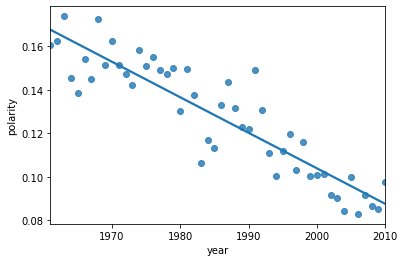

In [54]:
#%pip install seaborn
import seaborn as sns

data_df = df.groupby(['year']).mean().reset_index()
data_df = data_df[data_df['year'].astype(int) > 1960]
sns_plot = sns.regplot(data_df['year'].astype(int), data_df['polarity'], order=1, ci=None)
# sns_plot.figure.savefig('polarity.pdf')

# Data Preparation

We extract our target variable (hit or not) from the dataset. Then, we drop irrelevant and non-numerical columns from the dataset to form our x inputs.

The dataset is then split into training and validation sets. The new datasets are not shuffled to ensure that the lyrics correspond to the correct auxiliary variables.

In [55]:
import sklearn as sk
from sklearn.model_selection import train_test_split

y_data = df['hit']
x_data = df.drop(['hit', 'artist', 'artist_id', 'isrc', 'lyrics', 'song', 'id', 'spotify_track_id', 'spotify_track_album', 'analysis_url', 'uri', 'track_href', 'type', 'current_popularity'], axis=1, inplace=False)
print(x_data.columns)
x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(
    x_data, y_data, test_size=0.2, shuffle=False
)

lyrics_train, lyrics_eval = train_test_split(df['lyrics'], test_size=0.2, shuffle=False)
print(len(y_data_train))
print(len(lyrics_train))
print(len(x_data_train))
print(y_data_train.describe())

Index(['year', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature',
       'artist_popularity', 'artist_num_hits', 'polarity', 'subjectivity',
       'lyric_length'],
      dtype='object')
27303
27303
27303
count    27303.000000
mean         0.516647
std          0.499732
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: hit, dtype: float64


In [56]:
polarity_mean = x_data_train['polarity'].mean()
subjectivity_mean = x_data_train['subjectivity'].mean()

pd.options.mode.chained_assignment = None  # default='warn'

x_data_train['polarity'] = x_data_train['polarity'].fillna(polarity_mean)
x_data_test['polarity'] = x_data_test['polarity'].fillna(polarity_mean)
x_data_train['subjectivity'] = x_data_train['subjectivity'].fillna(subjectivity_mean)
x_data_test['subjectivity'] = x_data_test['subjectivity'].fillna(subjectivity_mean)

We then scale our auxiliary input variables using the StandardScaler.

In [57]:
from sklearn.preprocessing import StandardScaler

scaler_model = StandardScaler()

x_data_train = pd.DataFrame(
    scaler_model.fit_transform(x_data_train),
    columns=x_data_train.columns,
    index=x_data_train.index
)
x_data_test = pd.DataFrame(
    scaler_model.transform(x_data_test),
    columns=x_data_test.columns,
    index=x_data_test.index
)

# Simple Classification Models

The below code blocks show the results of the classification task using the auxiliary variables alone as inputs into various classifier models.

In [58]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0).fit(x_data_train, y_data_train)
print(round(LR.score(x_data_test, y_data_test), 4))
lr_preds = LR.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, lr_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, lr_preds))

0.8175
(0.8391821788220933, 0.7927356586912655, 0.8152979543433146, None)
[[2830  527]
 [ 719 2750]]


In [59]:
SVM = sk.svm.SVC()
SVM.fit(x_data_train, y_data_train)
print(round(SVM.score(x_data_test, y_data_test), 4))
svm_preds = SVM.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, svm_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, svm_preds))

0.8276
(0.8394549763033176, 0.8169501297203805, 0.8280496712929145, None)
[[2815  542]
 [ 635 2834]]


In [60]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=500, max_depth=100, random_state=0)
RF.fit(x_data_train, y_data_train)
print(round(RF.score(x_data_test, y_data_test), 4))
rf_preds = RF.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, rf_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, rf_preds))

0.8554
(0.842439293598234, 0.8800807149034304, 0.8608487240941773, None)
[[2786  571]
 [ 416 3053]]


In [61]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='adam', alpha=0.01, hidden_layer_sizes=(30, 10, 10), random_state=1, activation='relu')
NN.fit(x_data_train, y_data_train)
print(round(NN.score(x_data_test, y_data_test), 4))
nn_preds = NN.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, nn_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, nn_preds))

0.8444
(0.8385372714486639, 0.8593254540213318, 0.8488041002277904, None)
[[2783  574]
 [ 488 2981]]


In [62]:
from sklearn.naive_bayes import BernoulliNB

NB = BernoulliNB()
NB.fit(x_data_train, y_data_train)
print(round(NB.score(x_data_test, y_data_test), 4))
nb_preds = NB.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, nb_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, nb_preds))

0.7885
(0.8043282236248873, 0.7714038627846642, 0.7875220718069453, None)
[[2706  651]
 [ 793 2676]]


In [ ]:
from embeddings import EmbeddingGenerator

embedding = EmbeddingGenerator(
    max_sequence_len=300,
    filename='glove.840B.300d.txt'
)

print('Pretrained embedding loaded')
print('Embedding dimension:', embedding.embedding_dimension)

embedding.generate_word_index(texts=lyrics_train)  # Fits Tokenizer on words in X training data
print('Word index:', len(embedding.word_index))

# The below generate_sequences lines converts the words into integers,
# using the word indexes from the training data
seqs_train = embedding.generate_sequences(lyrics_train)
seqs_eval = embedding.generate_sequences(lyrics_eval)

print('Sequences created')

embedding.generate_embedding_matrix()

print('Vocab size:', embedding.vocab_size)
print(embedding.embedding_matrix.shape)


with open('embedding-year-300.pickle', 'wb') as f:
    pickle.dump(embedding, f)

In [19]:
with open('embedding-year-300.pickle', 'rb') as f:
    embedding = pickle.load(f)
    
seqs_train = embedding.generate_sequences(lyrics_train)
seqs_eval = embedding.generate_sequences(lyrics_eval)

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Embedding, \
    Input, Flatten, MaxPooling1D, Conv1D, concatenate, LSTM
from tensorflow.keras.models import Model

In [35]:
print('Building model...')

lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.00)

# Branch 1
aux_input = Input(shape=(len(x_data_train.columns),))
aux = Dense(400, activation=lrelu)(aux_input)
aux = BatchNormalization()(aux)
aux = Model(inputs=aux_input, outputs=aux)

# Branch 2
emb_input = Input(shape=(embedding.max_sequence_len,))
emb = Embedding(embedding.vocab_size, embedding.embedding_dimension,
                input_length=embedding.max_sequence_len,
                weights=[embedding.embedding_matrix],
                trainable=True)(emb_input)
emb = Conv1D(filters=16, kernel_size=4, activation=lrelu)(emb)
emb = LSTM(50)(emb)
emb = BatchNormalization()(emb)
emb = Dropout(.2)(emb)
emb = Dense(200, activation=lrelu)(emb)
emb = BatchNormalization()(emb)
emb = Dropout(.2)(emb)
emb = Dense(200, activation=lrelu)(emb)
emb = BatchNormalization()(emb)
emb = Dropout(.2)(emb)
emb = Dense(200, activation=lrelu)(emb)
emb = BatchNormalization()(emb)
emb = Dropout(.2)(emb)
emb = Dense(200, activation=lrelu)(emb)
emb = BatchNormalization()(emb)
emb = Dropout(.2)(emb)
emb = Dense(200, activation=lrelu)(emb)
emb = BatchNormalization()(emb)
emb = Dropout(.2)(emb)
emb = Dense(200, activation=lrelu)(emb)
emb = BatchNormalization()(emb)
emb = Model(inputs=emb_input, outputs=emb)

# Combined
combined = concatenate([aux.output, emb.output])
z = Dense(100, activation=lrelu)(combined)
z = BatchNormalization()(z)
z = Dropout(.2)(z)
z = Dense(100, activation=lrelu)(z)
z = BatchNormalization()(z)
z = Dropout(.2)(z)
z = Dense(100, activation=lrelu)(z)
z = BatchNormalization()(z)
z = Dropout(.2)(z)
z = Dense(100, activation=lrelu)(z)
z = BatchNormalization()(z)
z = Dropout(.2)(z)
z = Dense(100, activation=lrelu)(z)
z = BatchNormalization()(z)
z = Dropout(.2)(z)
z = Dense(100)(z)
z = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[aux.input, emb.input], outputs=z)

optimizer = keras.optimizers.SGD(0.01) # Try RMSprop too?

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, verbose=1)

print(x_data_train.shape)
print(seqs_train.shape)
# print(model.summary())

Building model...
(27304, 20)
(27304, 300)


In [36]:
history = model.fit(
    [x_data_train, seqs_train],
    y_data_train,
    validation_data=([x_data_test, seqs_eval], y_data_test),
    batch_size=64,
    epochs=200,
    shuffle=True,
    verbose=1,
    callbacks=[es, rlr]
)

Epoch 1/200
427/427 [==============================] - 16s 38ms/step - loss: 0.6041 - acc: 0.6835 - precision_6: 0.7004 - recall_6: 0.6767 - val_loss: 0.4996 - val_acc: 0.7691 - val_precision_6: 0.8416 - val_recall_6: 0.6722
Epoch 2/200
427/427 [==============================] - 15s 36ms/step - loss: 0.5058 - acc: 0.7674 - precision_6: 0.7741 - recall_6: 0.7763 - val_loss: 0.4512 - val_acc: 0.8021 - val_precision_6: 0.8275 - val_recall_6: 0.7714
Epoch 3/200
427/427 [==============================] - 16s 36ms/step - loss: 0.4784 - acc: 0.7886 - precision_6: 0.7927 - recall_6: 0.8001 - val_loss: 0.4361 - val_acc: 0.8106 - val_precision_6: 0.8303 - val_recall_6: 0.7884
Epoch 4/200
427/427 [==============================] - 16s 38ms/step - loss: 0.4612 - acc: 0.7984 - precision_6: 0.7997 - recall_6: 0.8136 - val_loss: 0.4204 - val_acc: 0.8236 - val_precision_6: 0.8332 - val_recall_6: 0.8164
Epoch 5/200
427/427 [==============================] - 15s 36ms/step - loss: 0.4480 - acc: 0.8072 - 

In [73]:
pred_train = model.evaluate([x_data_train, seqs_train], y_data_train)
pred_test = model.evaluate([x_data_test, seqs_eval], y_data_test)
y_pred_train = model.predict([x_data_train, seqs_train]).astype('int').flatten()
y_pred = model.predict([x_data_test, seqs_eval]).astype('int').flatten()

214/214 [==============================] - 2s 9ms/step - loss: 0.3509 - acc: 0.8639 - precision_6: 0.8440 - recall_6: 0.8982


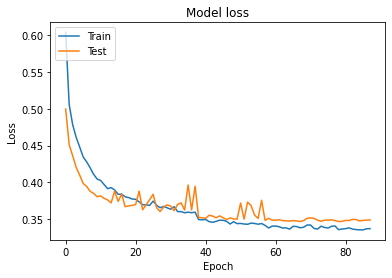

In [39]:
#%pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

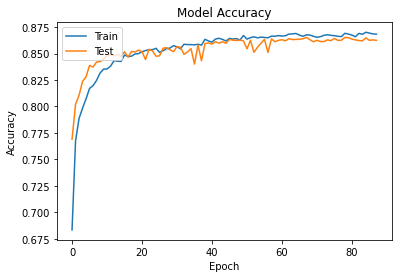

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# %pip install seaborn
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

df_corr = pd.DataFrame() # Correlation matrix
df_p = pd.DataFrame()  # Matrix of p-values
for x in x_data.columns:
    # for y in full_df.columns:
    corr = pearsonr(x_data[x].astype(float), y_data)
    df_corr.loc[x,0] = corr[0]
    df_p.loc[x,0] = corr[1]


# mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
cmap = sns.diverging_palette(240, 10, as_cmap=True)

f = plt.figure(figsize=(8, 7))
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)
ax = sns.heatmap(df_corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .6})
ax.set_title('Pearson Correlation Matrix')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(8, 7))
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)
ax = sns.heatmap(df_p, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .6})
ax.set_title('P-Value Matrix from Pearson Correlation')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()
plt.show()